<a href="https://colab.research.google.com/github/DSNortsev/TensorFlow/blob/master/TaxiFare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# The datetime module used to work with dates as date objects.
import datetime
# The OS module in python provides functions for interacting with the operating system.
import os
# The shutil module in Python provides many functions of high-level operations on files and collections of files.
# This module helps in automating process of copying and removal of files and directories.
import shutil

# Here we'll import data processing libraries like Numpy, Pandas and Tensorflow
import numpy as np
import pandas as pd
import tensorflow as tf

# Import pyplot package from matplotlib library
from matplotlib import pyplot as plt
# Import keras package from tensorflow library
from tensorflow import keras

# Import Sequential function from tensorflow.keras.models
from tensorflow.keras.models import Sequential
# Import Dense, DenseFeatures function from tensorflow.keras.layers
from tensorflow.keras.layers import Dense, DenseFeatures
# Import TensorBoard function from tensorflow.keras.callbacks
from tensorflow.keras.callbacks import TensorBoard

# Here we'll show the currently installed version of TensorFlow
print(tf.__version__)
%matplotlib inline

2.4.1


In [4]:
!ls -l taxi*.csv

-rw-r--r-- 1 root root 123590 Apr 18 04:11 taxi-test.csv
-rw-r--r-- 1 root root 579055 Apr 18 04:11 taxi-train.csv
-rw-r--r-- 1 root root 123114 Apr 18 04:11 taxi-valid.csv


In [6]:
!head taxi*.csv

==> taxi-test.csv <==
6.0,2013-03-27 03:35:00 UTC,-73.977672,40.784052,-73.965332,40.801025,2,0
19.3,2012-05-10 18:43:16 UTC,-73.954366,40.778924,-74.004094,40.723104,1,1
7.5,2014-05-20 23:09:00 UTC,-73.999165,40.738377,-74.003473,40.723862,2,2
12.5,2015-02-23 19:51:31 UTC,-73.9652099609375,40.76948165893555,-73.98949432373047,40.739742279052734,1,3
10.9,2011-03-19 03:32:00 UTC,-73.99259,40.742957,-73.989908,40.711053,1,4
7.0,2012-09-18 12:51:11 UTC,-73.971195,40.751566,-73.975922,40.756361,1,5
19.0,2014-05-20 23:09:00 UTC,-73.998392,40.74517,-73.939845,40.74908,1,6
8.9,2012-07-18 08:46:08 UTC,-73.997638,40.756541,-73.973303,40.762019,1,7
4.5,2010-07-11 20:39:08 UTC,-73.976738,40.751321,-73.986671,40.74883,1,8
7.0,2013-12-12 02:16:40 UTC,-73.985024,40.767537,-73.981273,40.779302,1,9

==> taxi-train.csv <==
11.3,2011-01-28 20:42:59 UTC,-73.999022,40.739146,-73.990369,40.717866,1,0
7.7,2011-06-27 04:28:06 UTC,-73.987443,40.729221,-73.979013,40.758641,1,1
10.5,2011-04-03 00:54:53 UTC,-73.

In [8]:
# Defining the feature names into a list `CSV_COLUMNS`
CSV_COLUMNS = [
    'fare_amount',
    'pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'key'
]
LABEL_COLUMN = 'fare_amount'
# Defining the default values into a list `DEFAULTS`
DEFAULTS = [[0.0], ['na'], [0.0], [0.0], [0.0], [0.0], [0.0], ['na']]
UNWANTED_COLS = ['pickup_datetime', 'key']


def features_and_labels(row_data):
# The .pop() method will return item and drop from frame. 
    label = row_data.pop(LABEL_COLUMN)
    features = row_data
    
    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)

    return features, label


def create_dataset(pattern, batch_size=1, mode='eval'):
# The tf.data.experimental.make_csv_dataset() method reads CSV files into a dataset
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS)

# The map() function executes a specified function for each item in an iterable.
# The item is sent to the function as a parameter.
    dataset = dataset.map(features_and_labels)

    if mode == 'train':
# The shuffle() method takes a sequence (list, string, or tuple) and reorganize the order of the items.
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

In [10]:
# Defining the feature names into a list `INPUT_COLS`
INPUT_COLS = [
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
]

# Create input layer of feature columns
# TODO 1
feature_columns = {
    colname: tf.feature_column.numeric_column(colname)
    for colname in INPUT_COLS
    }

In [11]:
# Build a keras DNN model using Sequential API
# TODO 2a
model = Sequential([
    DenseFeatures(feature_columns=feature_columns.values()),
    Dense(units=32, activation="relu", name="h1"),
    Dense(units=8, activation="relu", name="h2"),
    Dense(units=1, activation="linear", name="output")
    ])

In [12]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


# Compile the keras model
model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

In [14]:
TRAIN_BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS = 50  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern='taxi-train*',
    batch_size=TRAIN_BATCH_SIZE,
    mode='train')

evalds = create_dataset(
    pattern='taxi-valid*',
    batch_size=1000,
    mode='eval').take(NUM_EVAL_EXAMPLES//1000)

In [23]:
trainds

<PrefetchDataset shapes: (OrderedDict([(pickup_longitude, (1000,)), (pickup_latitude, (1000,)), (dropoff_longitude, (1000,)), (dropoff_latitude, (1000,)), (passenger_count, (1000,))]), (1000,)), types: (OrderedDict([(pickup_longitude, tf.float32), (pickup_latitude, tf.float32), (dropoff_longitude, tf.float32), (dropoff_latitude, tf.float32), (passenger_count, tf.float32)]), tf.float32)>

In [18]:
%time 
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

LOGDIR = "taxi_trained"
# Train the sequential model
history = model.fit(x=trainds,
                    steps_per_epoch=steps_per_epoch,
                    epochs=NUM_EVALS,
                    validation_data=evalds,
                    callbacks=[TensorBoard(LOGDIR)])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
1/1 [==============================] - ETA: 0s - loss: 1169.8442 - rmse: 34.2030 - mse: 1169.8442WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'collections.OrderedDict'> input: OrderedDict([('pickup_longitude', <tf.Tensor 'ExpandDims_4:0' shape=(1000, 1) dtype=float32>), ('pickup_latitude', <tf.Tensor 'ExpandDims_3:0' shape=(1000, 1) dtype=float32>), ('dropoff_longitude', <tf.Tensor 'ExpandDims_1:0' shape=(1000, 1) dtype=float32>), ('dropoff_latitude', <tf.Tensor 'ExpandDims:0' shape=(1000, 1) dtype=float32>), ('passenger_count', <tf.Tensor 'ExpandDims_2:0' shape=(1000, 1) dtype=float32>)])
Consider rewriting this model with the Functional API.
1/1 [==============================] - 13s 13s/step - loss: 1169.8442 - rmse: 34.2030 - mse: 116

In [19]:
# The summary() is a generic function used to produce result summaries of the results of various model fitting functions.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  0         
_________________________________________________________________
h1 (Dense)                   multiple                  192       
_________________________________________________________________
h2 (Dense)                   multiple                  264       
_________________________________________________________________
output (Dense)               multiple                  9         
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________


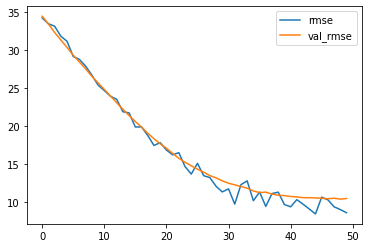

In [20]:
RMSE_COLS = ['rmse', 'val_rmse']

# The history object is returned from calls to the fit() function used to train the model.
# Metrics are stored in a dictionary in the history member of the object returned.
pd.DataFrame(history.history)[RMSE_COLS].plot()

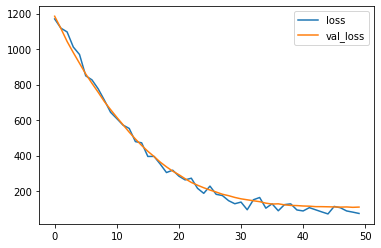

In [21]:
LOSS_COLS = ['loss', 'val_loss']

# The history object is returned from calls to the fit() function used to train the model.
# Metrics are stored in a dictionary in the history member of the object returned.
pd.DataFrame(history.history)[LOSS_COLS].plot()

In [31]:
# The predict() method will predict the response for model. 
# Using tf.convert_to_tensor() we will convert the given value to a Tensor. 
from collections import OrderedDict
model.predict(x={"pickup_longitude": tf.convert_to_tensor([-73.982683]),
                 "pickup_latitude": tf.convert_to_tensor([40.742104]),
                 "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
                 "dropoff_latitude": tf.convert_to_tensor([40.755174]),
                 "passenger_count": tf.convert_to_tensor([3.0])},
              steps=1)

array([[11.916386]], dtype=float32)

In [32]:
# TODO 4a
OUTPUT_DIR = "export/savedmodel"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
# The join() method takes all items in an iterable and joins them into one string.
EXPORT_PATH = os.path.join(OUTPUT_DIR,
                           datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
tf.saved_model.save(model, EXPORT_PATH)  # with default serving function

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
INFO:tensorflow:Assets written to: export/savedmodel/20210418042533/assets


In [35]:
# Export the model to a TensorFlow SavedModel format
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir {EXPORT_PATH}
!find {EXPORT_PATH}
os.environ['EXPORT_PATH'] = EXPORT_PATH

The given SavedModel SignatureDef contains the following input(s):
  inputs['dropoff_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_dropoff_latitude:0
  inputs['dropoff_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_dropoff_longitude:0
  inputs['passenger_count'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_passenger_count:0
  inputs['pickup_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_pickup_latitude:0
  inputs['pickup_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_pickup_longitude:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict
export/savedmodel/20210418042533
export/savedmod